In [138]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from src.network.multilayernetwork import MLP
from src.utils.data_utils import get_CIFAR10_data
from src.utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from src.train.solver import Solver
from src.activation import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [88]:
# Affine Forward
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.986348504372948e-11
dw error:  9.904023583987626e-11
db error:  7.736978834487815e-12


In [89]:
# Affine backward
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  6.986348504372948e-11
dw error:  9.904023583987626e-11
db error:  7.736978834487815e-12


In [90]:
# Relu forward
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


In [91]:
# Relu backward
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# Initial Loss and gradient check

In [129]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = MLP([H1, H2], input_dim=D, num_classes=C, reg=reg, 
              weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for l in range(len(model.layers)):
    name_W = 'W%d'%(l+1)
    name_b = 'b%d'%(l+1)
    f = lambda _: model.loss(X,y)[0]
    layer = model.layers[l]
    grad_num = eval_numerical_gradient(f, layer.W, verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name_W, rel_error(grad_num, grads[name_W])))
    grad_num = eval_numerical_gradient(f, layer.b, verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name_b, rel_error(grad_num, grads[name_b])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
b1 relative error: 5.38e-09
W2 relative error: 2.21e-05
b2 relative error: 2.09e-09
W3 relative error: 3.53e-07
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.90e-09
b1 relative error: 1.48e-08
W2 relative error: 6.87e-08
b2 relative error: 1.72e-09
W3 relative error: 2.13e-08
b3 relative error: 1.57e-10


Also run solver on a 3-layer fully-connected network

(Iteration 1 / 40) loss: 2.296191
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.102000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.121000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.167000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.136000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.192000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.183000
(Iteration 11 / 40) loss: 1.044807
(Epoch 6 / 20) train acc: 0.680000; val_acc: 0.178000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.198000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.200000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.164000
(Epoch 10 / 20) train acc: 0.860000; val_acc: 0.158000
(Iteration 21 / 40) loss: 0.486950
(Epoch 11 / 20) train acc: 0.920000; val_acc: 0.186000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.175000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.193000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.172000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.204000
(Iteration 31 / 40) loss: 

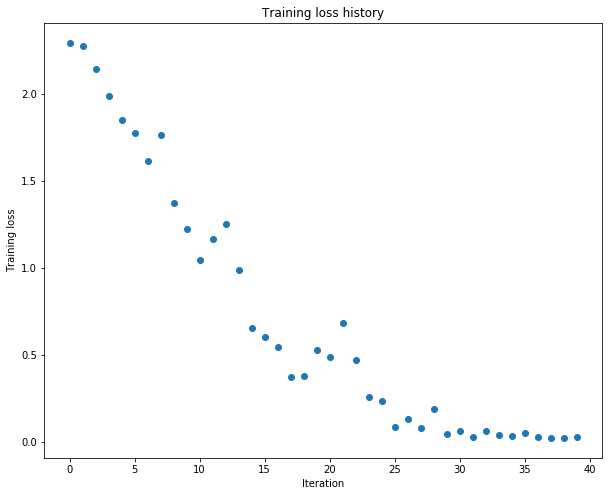

In [140]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = MLP([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Try to achieve 100 percent training using a 5-layer network

(Iteration 1 / 40) loss: 2.249582
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.090000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.131000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.156000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.098000
(Epoch 4 / 20) train acc: 0.560000; val_acc: 0.117000
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.124000
(Iteration 11 / 40) loss: 0.930292
(Epoch 6 / 20) train acc: 0.600000; val_acc: 0.128000
(Epoch 7 / 20) train acc: 0.760000; val_acc: 0.148000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.170000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.167000
(Epoch 10 / 20) train acc: 0.760000; val_acc: 0.130000
(Iteration 21 / 40) loss: 0.803384
(Epoch 11 / 20) train acc: 0.880000; val_acc: 0.180000
(Epoch 12 / 20) train acc: 0.860000; val_acc: 0.194000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.190000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.180000
(Epoch 15 / 20) train acc: 0.940000; val_acc: 0.160000
(Iteration 31 / 40) loss: 

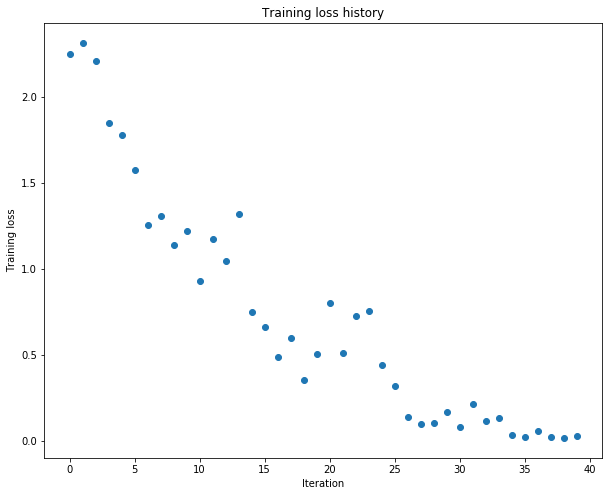

In [142]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = .021
weight_scale = .036
model = MLP([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()